In [34]:
# imports
#import numpy as np
import pandas as pd
import json
import requests
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# set up file paths and other data globals

import config, modify

# local imports

from covid_package.data_funcs.store_data import read_json_data, convert_owid_data, print_update_record
from covid_package.data_funcs.update_data import check_refresh_data

from covid_package.libs.valid_keys import fetch_l0_keys, fetch_l1_keys, fetch_l2_keys
from covid_package.libs.aggregate_data import fetch_latest_data_date, fetch_date_list
from covid_package.libs.country_list import fetch_countries

from covid_package.api.get_country_records import get_country_records
from covid_package.api.get_country_data import get_l0_data, get_l1_data, get_l2_iso_data, get_l2_date_data
from covid_package.api.get_case_death_data import get_case_death_stdev

#from covid_package.plots.plot_results import line_plot

#from covid_package.plots.plot_results import subplot_share_axis
print("Imports complete")

Imports complete


In [35]:
# update data

# check if data up to date; if not, reload
if check_refresh_data():
    # read the updated(?) data file from the data dir
    data = read_json_data(config.DATA_FILE_STR)
    # convert the OWID_ keys
    data = convert_owid_data(data)
    # repopulate the keys
    key_list = fetch_l0_keys(data)
    # need this?
    #country_list = fetch_countries(data)
    # get the date of the newest data records in owid-covid-data.json
    print("Latest data is:", fetch_latest_data_date(data, key_list))
    print("Current UTC 0 dateime = {}".format(datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S%z")))

Checking that data is up to date
Data file up to date
Latest data is: 2021-05-25
Current UTC 0 dateime = 2021-05-26T00:59:49


In [36]:
#[print(k) for k in key_list]

# get the data for a single country
#print(get_l0_data(data, 'CYN'))

# get the level 1 data for all countries
l1_data = get_l1_data(data, key_list, ['location'])
this_country = "Thailand"
[print("The key for {} is {}".format(vals['location'], key)) for key, vals in l1_data.items() if this_country in vals['location']]

# list of valid level 1 keys
#print(fetch_l1_keys(data, key_list))

# list of valid level 2 keys
#print(fetch_l2_keys(data, key_list))

# for each country, get record numbers and data dates
#print(get_country_records(data, key_list))

The key for Thailand is THA


[None]

In [37]:
# get an exhaustive list of dates in the data
date_list = fetch_date_list(data, key_list)

# define the list of required resources
#res = ['people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']
res = ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million']

# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, key_list, date_list, res)# cycle through each day's collections of new cases and new deaths

# truncate today's (zulu time) data, as it will almost certainly be incomplete
this_date = datetime.utcnow().strftime("%Y-%m-%d")

if this_date in country_date_data.keys():
    country_date_data.pop(this_date)
print("UTC 0 today's data ({}) has been discarded as it is incomplete.".format(this_date))

date_dict = dict()
for day in country_date_data:

    #print(country_date_data[day])

    # calculate the wrl_new_ cases/deaths _per_million
    if country_date_data[day]['WRL'][0]:
        wrl_new_cases_pm = country_date_data[day]['WRL'][0]
    else:
        wrl_new_cases_pm = 0
    
    if country_date_data[day]['WRL'][1]:
        wrl_new_deaths_pm = country_date_data[day]['WRL'][1]
    else:
        wrl_new_deaths_pm = 0

    # pop the wrl vals out of the structure
    # so they don't screw up the stdev calculation
    country_date_data[day].pop('WRL')

    # calculate the std dev for the day
    mean_stdev = get_case_death_stdev(country_date_data[day])

    # populate the date dict for this day
    date_dict[day] = {
        "wrl_new_cases_pm": wrl_new_cases_pm,
        "wrl_new_deaths_pm": wrl_new_deaths_pm,
        "stdev_new_cases_pm": mean_stdev[0],
        "stdev_new_deaths_pm": mean_stdev[1],
        "country_vals": country_date_data[day]
    }


print("date_dict compiled")
#test_date = '2021-05-04'
#print("date_dict for {}: {}".format(test_date, date_dict[test_date]))

UTC 0 today's data (2021-05-26) has been discarded as it is incomplete.
date_dict compiled


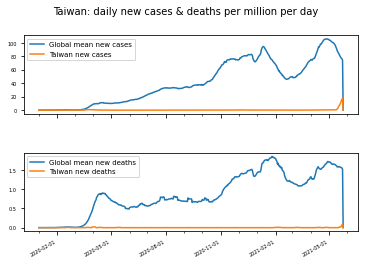

In [38]:
# re-juggle the data for a single country chart

# the country being analyzed
y_axis_values = 'TWN'

y_axis_label = data[y_axis_values]['location']

# declare the axis vars
x_axis = []
yw1_axis = []
y1_axis = []
yw2_axis = []
y2_axis = []

# load the axis data lists
for key, val in date_dict.items():

    # list of dates for x axis
    x_axis.append(datetime.strptime(key, "%Y-%m-%d"))

    # lists of cases for y1 axis
    yw1_axis.append(val["wrl_new_cases_pm"])
    y1_axis.append(val['country_vals'][y_axis_values][0])
    
    # lists of deaths for y2 axis
    yw2_axis.append(val["wrl_new_deaths_pm"])
    y2_axis.append(val['country_vals'][y_axis_values][1])

###########################################################
# package up the matplotlib data for a single country chart
###########################################################

# create the labels
chart_title_str = "{}: daily new cases & deaths per million per day".format(y_axis_label)
x_axis_label_str = "Date"
# not currently using this - simplifying the output
#y1_axis_label_str = "New cases"
#y2_axis_label_str = "New deaths"

yw1_axis_legend_str = "Global mean new cases"
y1_axis_legend_str = "{} new cases".format(y_axis_label)

yw2_axis_legend_str = "Global mean new deaths"
y2_axis_legend_str = "{} new deaths".format(y_axis_label)

# define empty canvas
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace = 0.5)

# declare the axis data
# subplot 1
ax1.plot(x_axis, yw1_axis, label = yw1_axis_legend_str)
ax1.plot(x_axis, y1_axis, label = y1_axis_legend_str)

# subplot 2
ax2.plot(x_axis, yw2_axis, label = yw2_axis_legend_str)
ax2.plot(x_axis, y2_axis, label = y2_axis_legend_str)
#ax2.set_xlabel(x_axis_label_str, fontsize=10)

# declare the text data
fig.suptitle(chart_title_str, fontsize = 10)

#  format the x axis (date) labels
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# major ticks every 3 months.
fmt_qtr_year = mdates.MonthLocator(interval = 3)
ax2.xaxis.set_major_locator(fmt_qtr_year)

# minor ticks every month.
fmt_month = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(fmt_month)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

# changing the fontsize of ticks
ax1.tick_params(labelsize = 5)
ax2.tick_params(labelsize = 5)

# format the legends
ax1.legend(loc = 0, fontsize = 7)
ax2.legend(loc = 0, fontsize = 7)

# display the plot
plt.show()


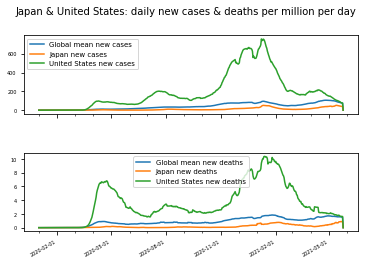

In [39]:
# re-juggle the data for a 2 country chart

# the countries being analyzed
yi_axis_values = 'JPN'
yii_axis_values = 'USA'

#y_axis_values_list = ["wrl_new_cases_pm", "KOR", "TWN"]

yi_axis_label = data[yi_axis_values]['location']
yii_axis_label = data[yii_axis_values]['location']

# declare the axis vars
x_axis = []
yw1_axis = []
y1i_axis = []
y1ii_axis = []
yw2_axis = []
y2i_axis = []
y2ii_axis = []

# load the axis data lists
for key, val in date_dict.items():

    # list of dates for x axis
    x_axis.append(datetime.strptime(key, "%Y-%m-%d"))

    # lists of cases for y1 axis
    yw1_axis.append(val["wrl_new_cases_pm"])
    y1i_axis.append(val['country_vals'][yi_axis_values][0])
    y1ii_axis.append(val['country_vals'][yii_axis_values][0])
    
    # lists of deaths for y2 axis
    yw2_axis.append(val["wrl_new_deaths_pm"])
    y2i_axis.append(val['country_vals'][yi_axis_values][1])
    y2ii_axis.append(val['country_vals'][yii_axis_values][1])

######################################################
# package up the matplotlib data for a 2 country chart
######################################################

# create the labels
chart_title_str = "{} & {}: daily new cases & deaths per million per day".format(yi_axis_label, yii_axis_label)
x_axis_label_str = "Date"
# not currently using this - simplifying the output
#y1_axis_label_str = "New cases"
#y2_axis_label_str = "New deaths"

yw1_axis_legend_str = "Global mean new cases"
y1i_axis_legend_str = "{} new cases".format(yi_axis_label)
y1ii_axis_legend_str = "{} new cases".format(yii_axis_label)

yw2_axis_legend_str = "Global mean new deaths"
y2i_axis_legend_str = "{} new deaths".format(yi_axis_label)
y2ii_axis_legend_str = "{} new deaths".format(yii_axis_label)

# define empty canvas
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
fig.subplots_adjust(hspace = 0.5)

# declare the axis data
# subplot 1
ax1.plot(x_axis, yw1_axis, label = yw1_axis_legend_str)
ax1.plot(x_axis, y1i_axis, label = y1i_axis_legend_str)
ax1.plot(x_axis, y1ii_axis, label = y1ii_axis_legend_str)

# subplot 2
ax2.plot(x_axis, yw2_axis, label = yw2_axis_legend_str)
ax2.plot(x_axis, y2i_axis, label = y2i_axis_legend_str)
ax2.plot(x_axis, y2ii_axis, label = y2ii_axis_legend_str)
#ax2.set_xlabel(x_axis_label_str, fontsize=10)

# declare the text data
fig.suptitle(chart_title_str, fontsize = 10)

#  format the x axis (date) labels
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# major ticks every 3 months.
fmt_qtr_year = mdates.MonthLocator(interval = 3)
ax1.xaxis.set_major_locator(fmt_qtr_year)
ax2.xaxis.set_major_locator(fmt_qtr_year)

# minor ticks every month.
fmt_month = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(fmt_month)
ax2.xaxis.set_minor_locator(fmt_month)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

# changing the fontsize of ticks
ax1.tick_params(labelsize = 5)
ax2.tick_params(labelsize = 5)

# format the legends
ax1.legend(loc = 0, fontsize = 7)
ax2.legend(loc = 0, fontsize = 7)

# display the plot
plt.show()
